In [1]:
# Building an Example Model TweetEngage

# Python
import os
import re
from collections import Counter

# Url
import requests

# Data Handling and Database Interaction
import pandas as pd
import psycopg2
from sqlalchemy import create_engine

# Visualization and Mapping
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import seaborn as sns
import geopandas as gpd
from wordcloud import WordCloud

# Text Processing and NLP
from nltk.corpus import stopwords
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import TfidfVectorizer

In [2]:
# OS review

USER = os.getenv('POSTGRES_USER')
PASSWORD = os.getenv('POSTGRES_PASSWORD')
DATABASE = os.getenv('POSTGRES_WAREHOUSE_DB')
HOST = os.getenv('POSTGRES_HOST')
HOST_PORT = os.getenv('POSTGRES_PORT')

print(
    f"""
    USER: {USER}
    PASSWORD: {PASSWORD}
    DATABASE: {DATABASE}
    HOST: {HOST}
    HOST_PORT: {HOST_PORT}
    """
)


    USER: postgres
    PASSWORD: password123
    DATABASE: smogsense
    HOST: postgres
    HOST_PORT: 5432
    


In [3]:
# Connection

db_address = f'postgresql://{USER}:{PASSWORD}@{HOST}:{HOST_PORT}/{DATABASE}'
conn = create_engine(db_address)

In [4]:
query = """
SELECT
    table_schema,
    table_name
FROM
    information_schema.tables
WHERE
    table_type = 'BASE TABLE'
    AND table_schema NOT IN ('pg_catalog', 'information_schema')
ORDER BY
    table_schema,
    table_name;
"""

In [5]:
# Checking the available data

aq_df = pd.read_sql(query, conn)
print(f"Air quality data shape: {aq_df.shape}")
aq_df.head(40)

Air quality data shape: (27, 2)


table_schema           table_name
0   air_quality_dim_annual_statistics          measurement
1   air_quality_dim_annual_statistics              station
2   air_quality_dim_annual_statistics       time_averaging
3   air_quality_dim_annual_statistics                 zone
4   air_quality_dim_annual_statistics            zone_type
5          air_quality_dim_integrated            indicator
6          air_quality_dim_integrated             province
7       air_quality_dim_map_pollutant             geometry
8       air_quality_dim_map_pollutant          measurement
9       air_quality_dim_map_pollutant            pollutant
10             air_quality_dim_sensor               sensor
11            air_quality_dim_station                 area
12            air_quality_dim_station             location
13            air_quality_dim_station              station
14                         health_dim   country_population
15                         health_dim        death_illness
16                         health_dim          measurement
17                         health_dim  province_population
18                             public      spatial_ref_sys
19                   social_media_dim         bounding_box
20                   social_media_dim           engagement
21                   social_media_dim              hashtag
22                   social_media_dim                place
23                   social_media_dim                tweet
24                   social_media_dim        tweet_hashtag
25                   social_media_dim                 user
26                      territory_dim             province

In [6]:
# Get annual air quality metrics
query = """
SELECT m.year, m."avg_μg_m3", m."max_μg_m3", z.zone_name, p.province, i.name as indicator_name
FROM air_quality_dim_annual_statistics.measurement m
JOIN air_quality_dim_annual_statistics.station s ON m.id_station = s.id_station
JOIN air_quality_dim_annual_statistics.zone z ON s.id_zone = z.id_zone
JOIN air_quality_dim_integrated.province p ON z.id_province = p.id_province
JOIN air_quality_dim_integrated.indicator i ON m.id_indicator = i.id_indicator
WHERE m.id_time_averaging = 1  -- Assuming annual averages
"""

In [7]:
aq_df = pd.read_sql(query, conn)
print(f"Air quality data shape: {aq_df.shape}")
aq_df.head()

Air quality data shape: (13272, 6)


year  avg_μg_m3  max_μg_m3    zone_name      province  indicator_name
0  2001   7.962667        NaN  dolnośląska  dolnośląskie  sulfur dioxide
1  2001  10.758238        NaN  dolnośląska  dolnośląskie  sulfur dioxide
2  2001  22.734209        NaN    Krakowska   małopolskie  sulfur dioxide
3  2001  14.879666        NaN    Krakowska   małopolskie  sulfur dioxide
4  2001  22.215205        NaN    Krakowska   małopolskie  sulfur dioxide

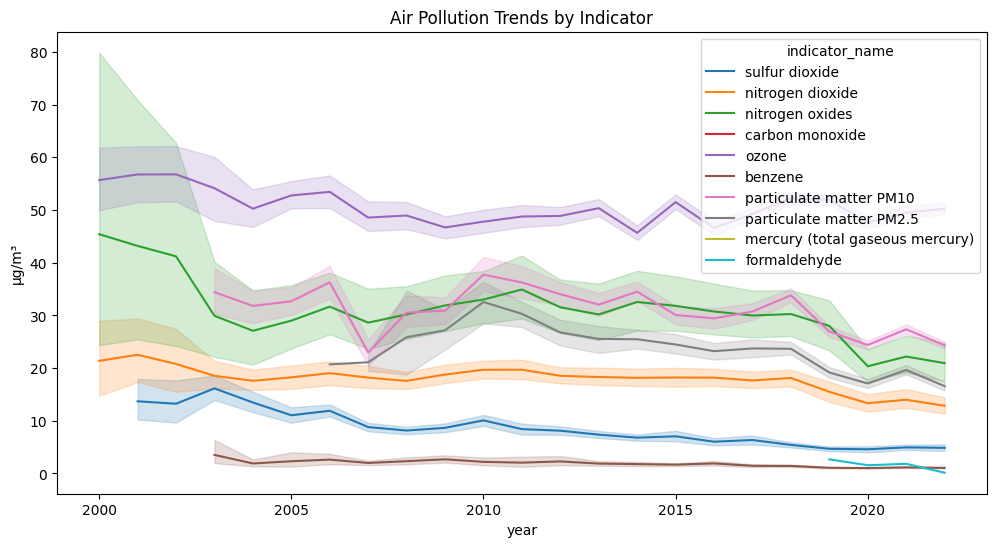

In [8]:
# Temporal trends

plt.figure(figsize=(12,6))
sns.lineplot(data=aq_df, x='year', y='avg_μg_m3', hue='indicator_name')
plt.title('Air Pollution Trends by Indicator')
plt.ylabel('μg/m³')
plt.show()

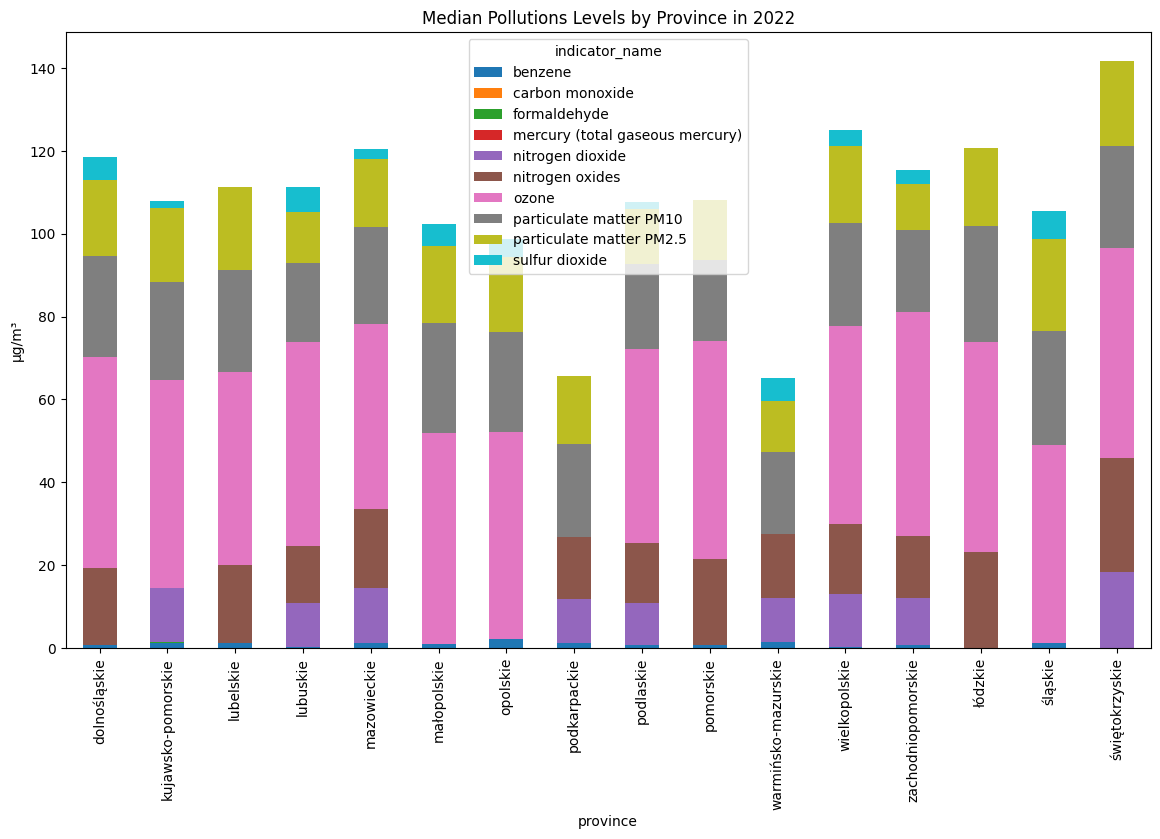

In [9]:
# Get the last available year
last_year = aq_df['year'].max()

# Filter the dataframe for only the last year
latest_data = aq_df[aq_df['year'] == last_year]

# Compute the mean only for the last year
province_avg = latest_data.groupby(['province', 'indicator_name'])['avg_μg_m3'].median().unstack()

# Plot
province_avg.plot(kind='bar', stacked=True, figsize=(14,8))
plt.title(f'Median Pollutions Levels by Province in {last_year}')
plt.ylabel('μg/m³')
plt.show()


In [10]:
## 2. Health Impact Analysis

# Get health data
health_query = """
SELECT m.year, m.deaths, d.illness, p.province 
FROM health_dim.measurement m
JOIN health_dim.death_illness d ON m.id_illness = d.id_illness
JOIN air_quality_dim_integrated.province p ON m.id_province = p.id_province
"""

health_df = pd.read_sql(health_query, conn)
print(f"Health data shape: {health_df.shape}")
health_df.head()

Health data shape: (3200, 4)


year  deaths                    illness     province
0  1999    6651  malignant neoplasms total  małopolskie
1  2000    6785  malignant neoplasms total  małopolskie
2  2001    6755  malignant neoplasms total  małopolskie
3  2002    6862  malignant neoplasms total  małopolskie
4  2003    7003  malignant neoplasms total  małopolskie

In [11]:
health_df['illness'].unique()

array(['malignant neoplasms total',
       'cancer of the trachea, bronchus and lung',
       'diseases of the circulatory system, total',
       'Diseases of the circulatory system - ischaemic heart disease',
       'Diseases of the circulatory system - cerebrovascular disease',
       'Diseases of the circulatory system - atherosclerotic vascular',
       'diseases of the respiratory system, total',
       'respiratory diseases - pneumonia, bronchitis, emphysema and asthma'],
      dtype=object)

In [12]:
aq_df['indicator_name'].unique()

array(['sulfur dioxide', 'nitrogen dioxide', 'nitrogen oxides',
       'carbon monoxide', 'ozone', 'benzene', 'particulate matter PM10',
       'particulate matter PM2.5', 'mercury (total gaseous mercury)',
       'formaldehyde'], dtype=object)

In [13]:
def display_pollution_levels_deaths_causes(death_cause: str):
    # Aggregate air quality data for "particulate matter PM2.5" by year and province
    aq_agg = (
        aq_df[aq_df['indicator_name'] == death_cause]
        .groupby(['year', 'province'])['avg_μg_m3']
        .mean()  # average concentration per province and year
        .reset_index()
    )

    # Pivot the health data so that each unique illness becomes a separate column with 'deaths' as the value
    health_pivot = health_df.pivot(index=['year', 'province'], columns='illness', values='deaths').reset_index()

    # Merge aggregated air quality data with the pivoted health data on year and province
    combined_df = pd.merge(aq_agg, health_pivot, on=['year', 'province'])

    # Identify columns corresponding to illnesses (i.e. all columns except 'year', 'province', and 'avg_μg_m3')
    illness_columns = [col for col in combined_df.columns if col not in ['year', 'province', 'avg_μg_m3']]

    # Compute the correlation matrix for PM2.5 and all illnesses
    corr_matrix = combined_df[['avg_μg_m3'] + illness_columns].corr()

    # Extract the correlations between avg_μg_m3 and each illness
    pm25_corr = corr_matrix.loc['avg_μg_m3', illness_columns]

    # Normalize correlation values for color mapping:
    norm = plt.Normalize(pm25_corr.min(), pm25_corr.max())
    colors = plt.cm.coolwarm(norm(pm25_corr.values))
    colors_list = list(colors)  # Convert the numpy array to a list for the palette

    # Plot the correlations in a horizontal bar plot using the hue parameter
    plt.figure(figsize=(10, 6))
    ax = sns.barplot(
        x=pm25_corr.values,
        y=pm25_corr.index,
        hue=pm25_corr.index,
        palette=colors_list,
        dodge=False  # Ensure one bar per illness without splitting by hue
    )
    # Remove the legend (hue is used solely for color mapping)
    if ax.get_legend() is not None:
        ax.get_legend().remove()

    plt.xlabel(f'Correlation with "{death_cause}" (avg_μg_m3)')
    plt.ylabel('Illness')
    plt.title(f'Correlation between "{death_cause}" and Deaths per Illness')
    plt.show()

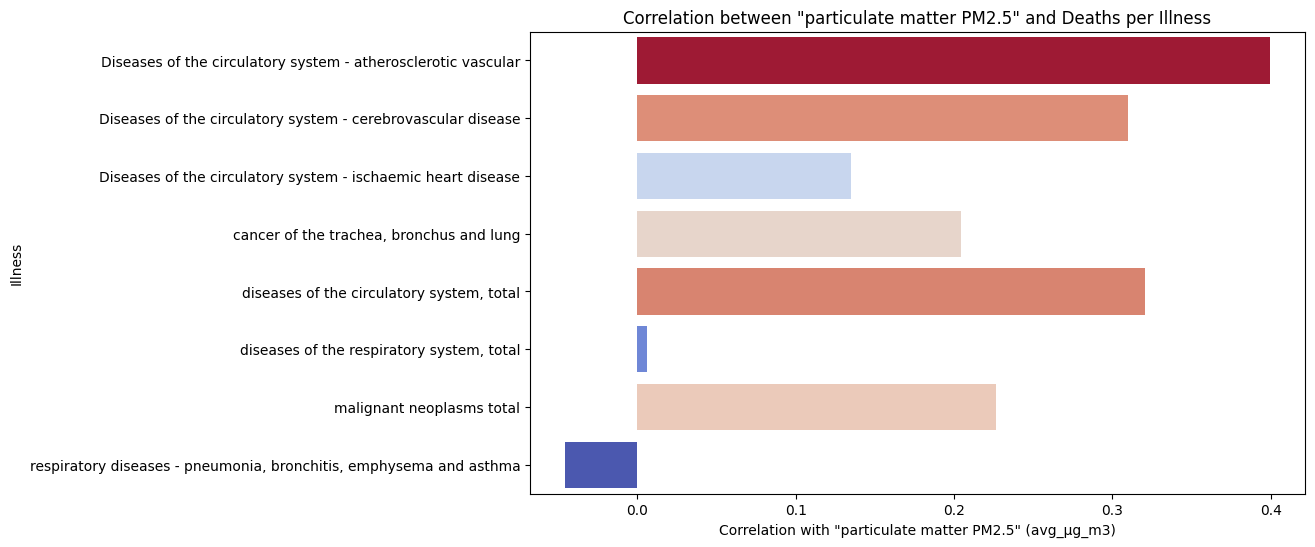

In [14]:
display_pollution_levels_deaths_causes('particulate matter PM2.5')

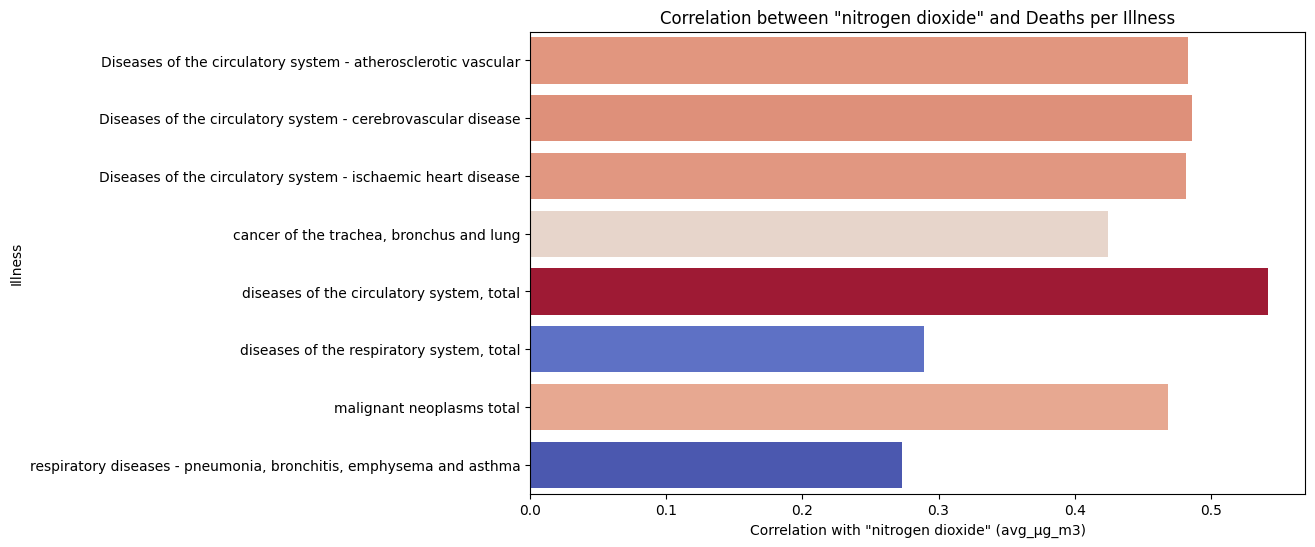

In [15]:
display_pollution_levels_deaths_causes('nitrogen dioxide')

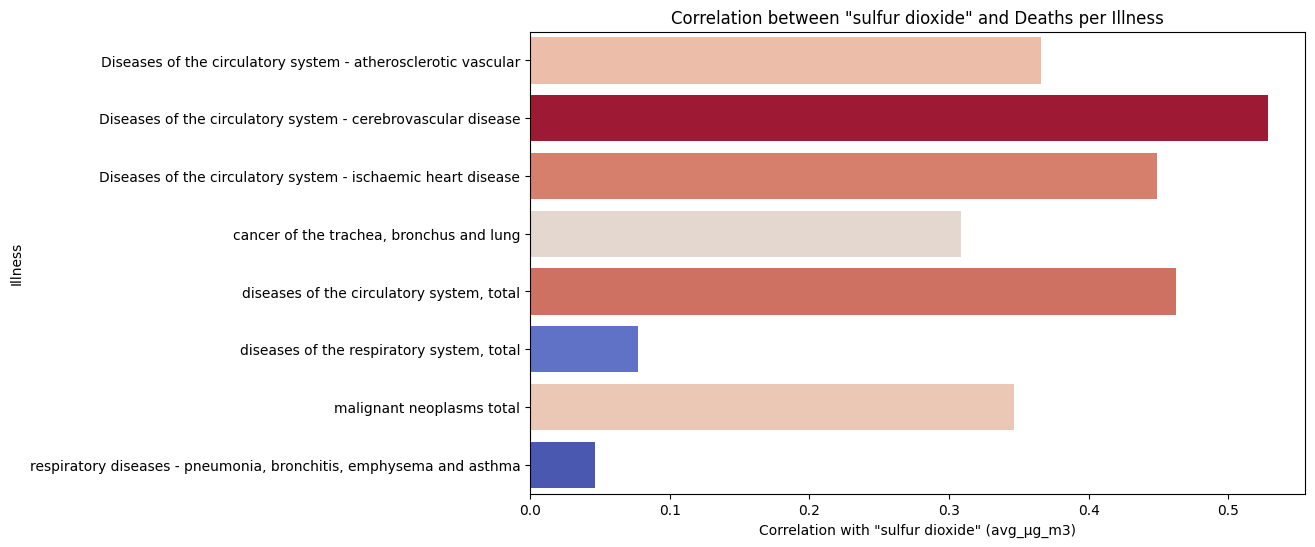

In [16]:
display_pollution_levels_deaths_causes('sulfur dioxide')

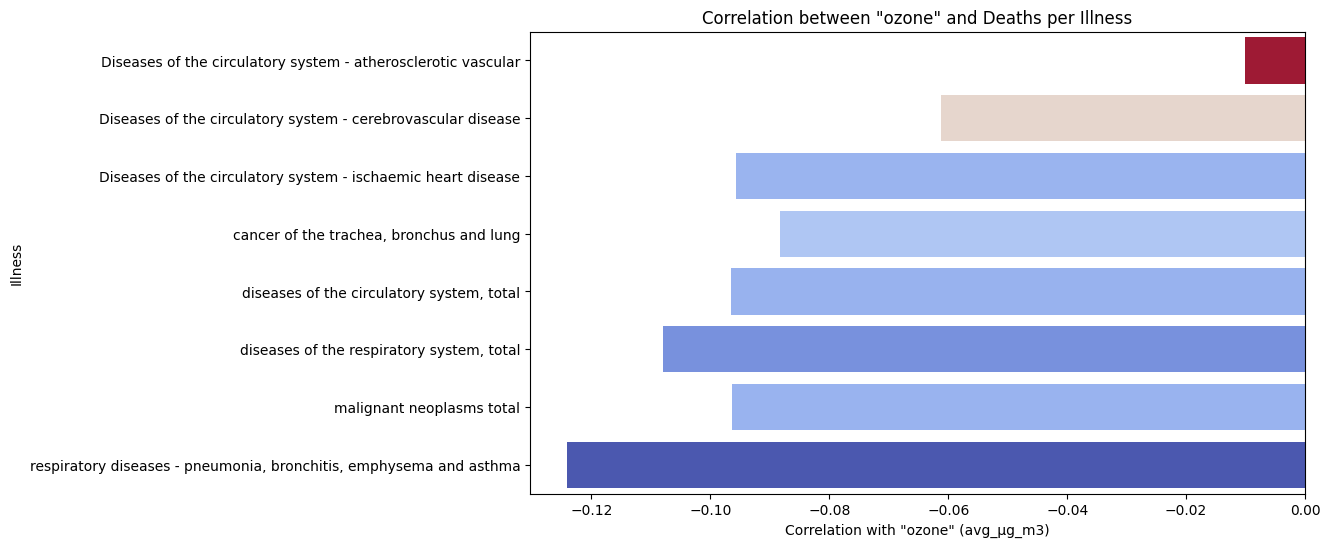

In [17]:
display_pollution_levels_deaths_causes('ozone')

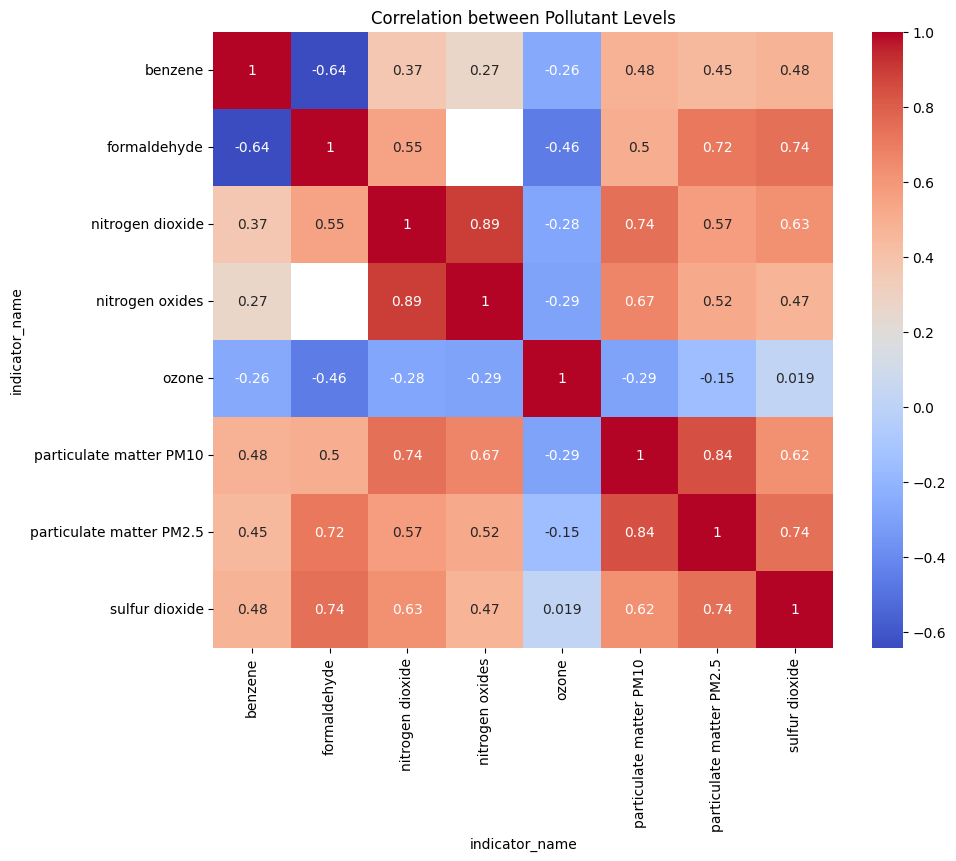

In [18]:
# Pivot the air quality data so that each pollutant becomes a separate column.
# The average pollutant level (avg_μg_m3) is aggregated by year and province.
pollutant_df = aq_df.pivot_table(
    index=['year', 'province'],       # Unique identifier for aggregation
    columns='indicator_name',         # Each pollutant becomes a column
    values='avg_μg_m3',               # Value to aggregate
    aggfunc='mean'                    # Compute the mean pollutant level
).reset_index()

# Identify the pollutant columns (exclude 'year' and 'province')
pollutant_columns = pollutant_df.columns.drop(['year', 'province'])

# Compute the correlation matrix between the pollutants
corr_matrix = pollutant_df[pollutant_columns].corr()

# Plot the correlation matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation between Pollutant Levels')
plt.show()

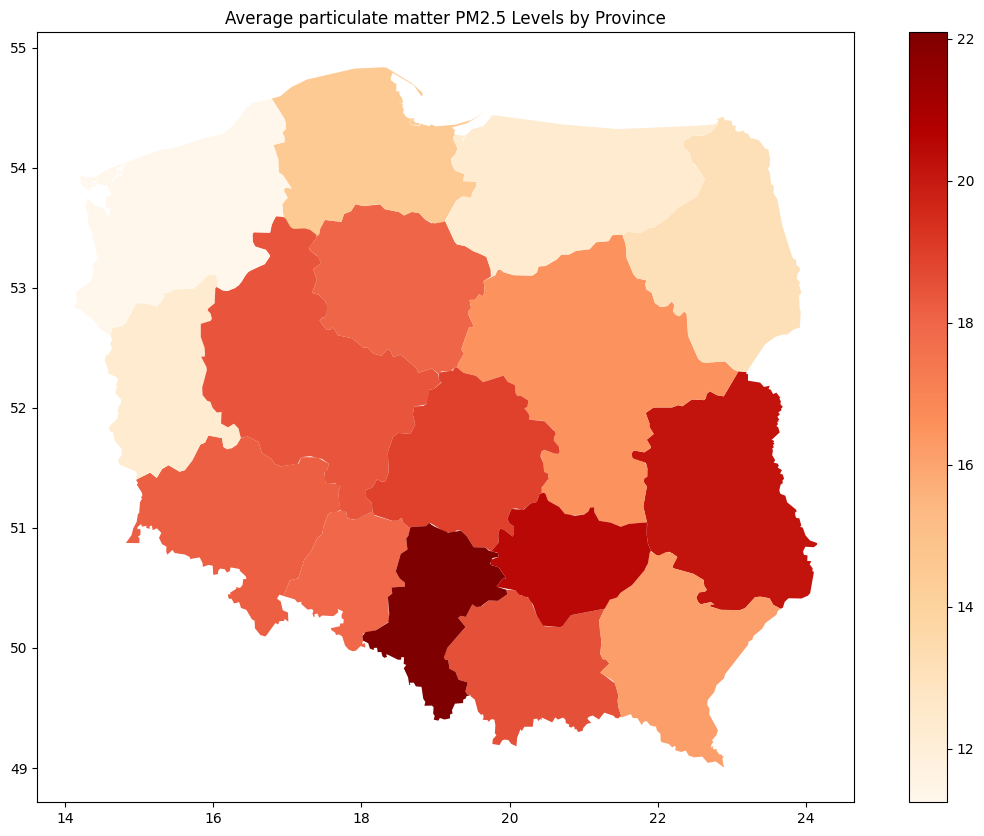

In [19]:
# Geospatial Analysis

geo_query = """
SELECT p.province, pr.coordinates 
FROM territory_dim.province pr
JOIN air_quality_dim_integrated.province p ON pr.id_province = p.id_province
"""

geo_df = gpd.GeoDataFrame.from_postgis(geo_query, conn, geom_col='coordinates')
geo_df = geo_df.merge(province_avg, on='province')

# Plot pollution map
def show_pollutions_by_province(pollution: str, cmap: str):
    fig, ax = plt.subplots(1,1, figsize=(14,10))
    geo_df.plot(column=pollution, cmap=cmap, legend=True, ax=ax)
    ax.set_title(f'Average {pollution} Levels by Province')
    plt.show()

show_pollutions_by_province('particulate matter PM2.5', 'OrRd')

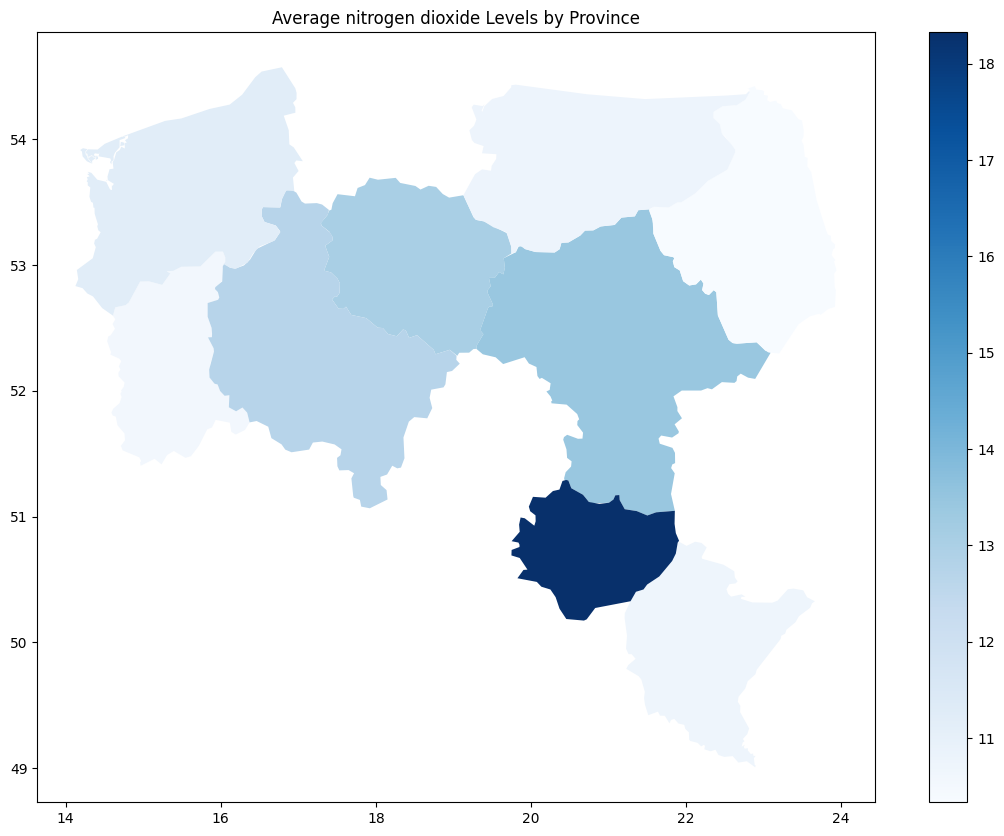

In [20]:
show_pollutions_by_province('nitrogen dioxide', 'Blues')

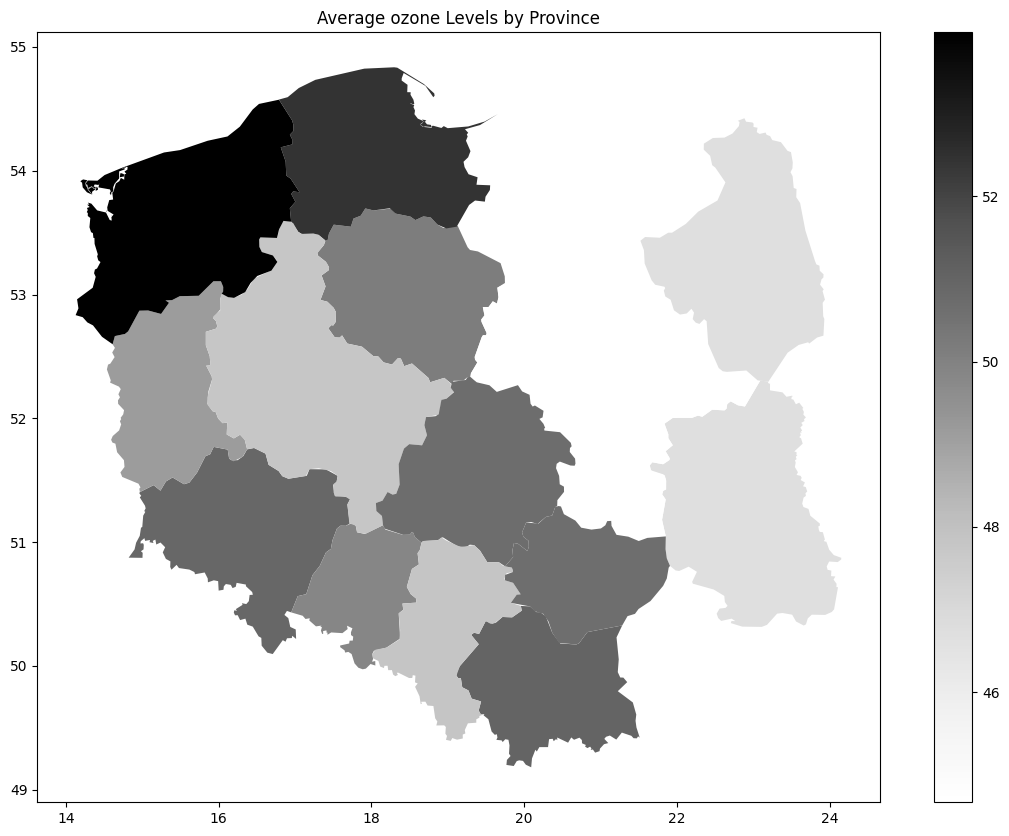

In [21]:
show_pollutions_by_province('ozone', 'Greys')

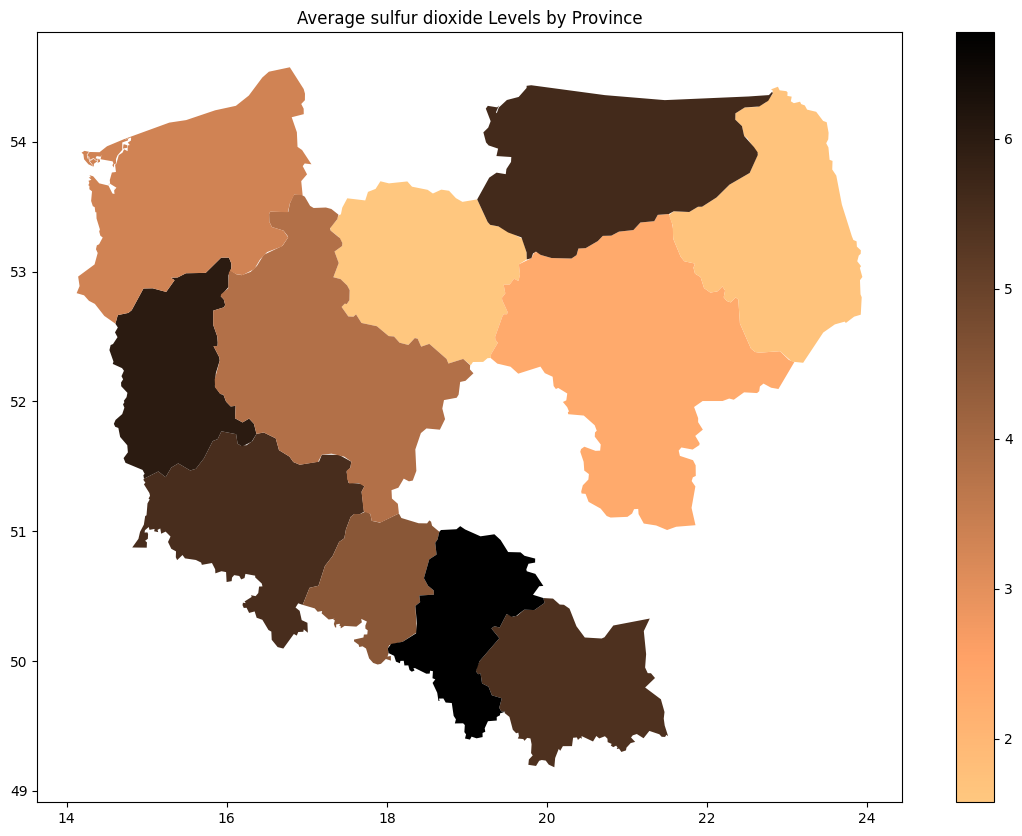

In [22]:
show_pollutions_by_province('sulfur dioxide', 'copper_r')

In [23]:
# Social Data analysis

social_query = """
WITH tweet_hashtags AS (
    SELECT 
        t.id_tweet, 
        string_agg(h.hashtag_name, ', ') AS hashtag_names
    FROM social_media_dim.tweet t
    JOIN social_media_dim.tweet_hashtag th ON t.id_tweet = th.id_tweet
    JOIN social_media_dim.hashtag h ON th.id_hashtag = h.id_hashtag
    GROUP BY t.id_tweet
)
SELECT 
    t.created_at, 
    e.*, 
    th.hashtag_names,
    t.text
FROM social_media_dim.tweet t
JOIN social_media_dim.engagement e ON t.id_tweet = e.id_tweet
JOIN tweet_hashtags th ON t.id_tweet = th.id_tweet
ORDER BY view_count DESC, like_count DESC, reply_count DESC, retweet_count DESC, quote_count DESC
"""

social_df = pd.read_sql(social_query, conn)
print(f"Social media data shape: {social_df.shape}")
social_df.head()


Social media data shape: (29, 9)


created_at             id_tweet  like_count  retweet_count  \
0 2025-01-02 13:33:08+00:00  1874811165882397091           6              0   
1 2025-01-01 10:08:15+00:00  1874397214375920034           7              0   
2 2025-01-11 10:02:31+00:00  1878019653114408968           4              0   
3 2025-01-08 17:11:11+00:00  1877040363833069870           2              1   
4 2025-01-11 14:04:53+00:00  1878080645856977294           1              3   

   quote_count  reply_count  view_count            hashtag_names  \
0            0            0         355       Kraków, Park, smog   
1            0            1         329                     smog   
2            1            1         325  czystepowietrze, fikcja   
3            0            0         243               LosAngeles   
4            1            0         196          smog, smogalert   

                                                text  
0  Krakowska maszyna do produkcji smogu! Szczotki...  
1  To taki sam filtr nowy i jeszcze nie do końca ...  
2  Dokładacie kopciuchów❗️\n.@MKiS_GOV_PL .@MRiTG...  
3  LA znamy z Hollywood, kalifornijskich plaż czy...  
4  Trwa masakrowanie Europy #smog-iem przez Belgi...

In [24]:
# Execute SQL query
query = """
SELECT * FROM public.most_engaged_hashtags
"""

df = pd.read_sql(query, conn)

# Create subplots
metrics = ['like_sum', 'retweet_sum', 'quote_sum', 'reply_sum', 'view_sum']
metric_names = ['Likes', 'Retweets', 'Quotes', 'Replies', 'Views']

fig = make_subplots(
    rows=5, 
    cols=1,
    shared_yaxes=True,
    subplot_titles=metric_names
)

# Add traces for each metric
for i, metric in enumerate(metrics, 1):
    fig.add_trace(
        go.Bar(
            x=df[metric],
            y=df['hashtag_name'],
            orientation='h',
            name=metric_names[i-1],
            text=df[metric],
            texttemplate='%{text:,}',
            hoverinfo='x'
        ),
        row=i, 
        col=1
    )

# Update layout
fig.update_layout(
    height=1200, 
    width=800,
    title_text='Top 10 Hashtags by Engagement Metrics (Ordered by Overall Rank)',
    showlegend=False,
    yaxis=dict(autorange="reversed")  # Top-ranked at the top
)

# Adjust subplot x-axis titles
for i in range(1, 6):
    fig['layout'][f'xaxis{i}']['title'] = 'Count'
    fig['layout'][f'yaxis{i}'].update(
        tickmode='array',
        tickvals=df['hashtag_name'],
        autorange="reversed"
    )
    
fig.show()

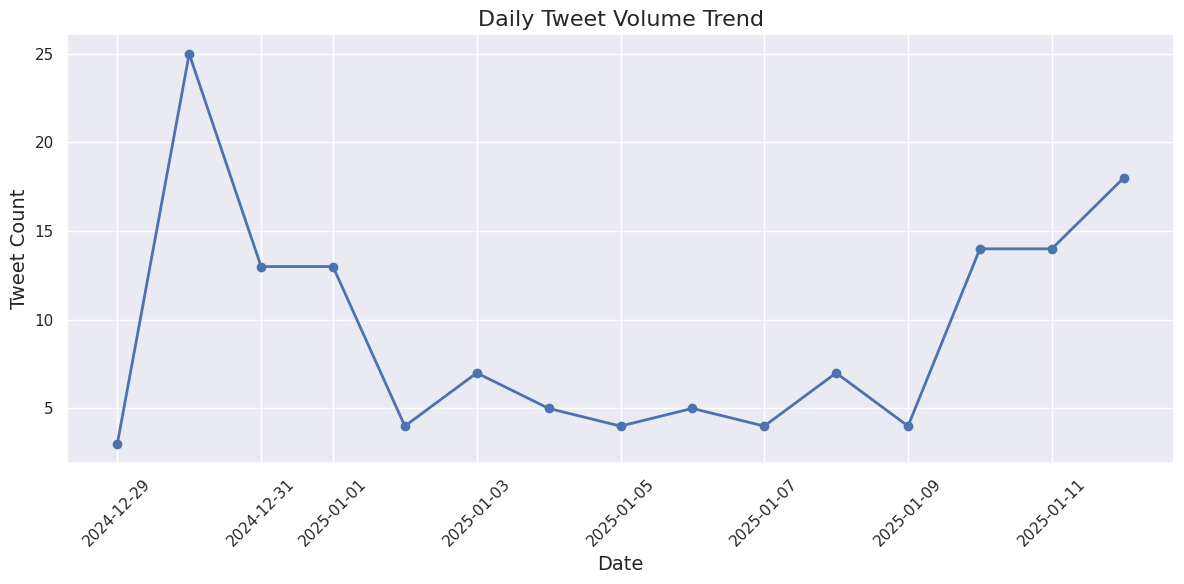

In [25]:
query = """
SELECT * FROM public.daily_tweet_volume_trend;
"""

df = pd.read_sql(query, conn)

# Plotting the time series data
plt.figure(figsize=(12, 6))
sns.set(style="darkgrid")
plt.plot(df['tweet_date'], df['tweet_count'], marker='o', color='b', linestyle='-', linewidth=2, markersize=6)
plt.title('Daily Tweet Volume Trend', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Tweet Count', fontsize=14)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

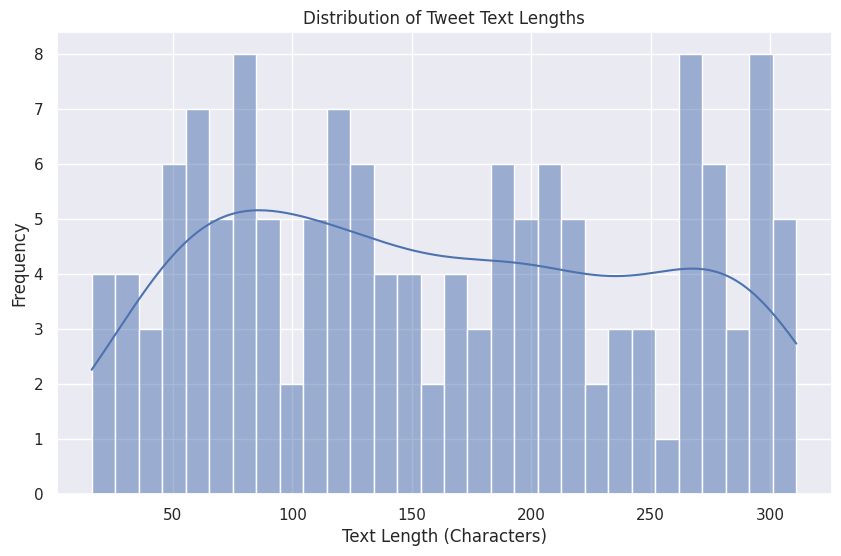

In [26]:
# Load the data
query = """
SELECT t.text 
FROM social_media_dim.tweet t
"""
df = pd.read_sql(query, conn)

# 1. Text length distribution
df['text_length'] = df['text'].apply(len)

# Plot text length distribution
plt.figure(figsize=(10, 6))
sns.histplot(df['text_length'], bins=30, kde=True)
plt.title("Distribution of Tweet Text Lengths")
plt.xlabel("Text Length (Characters)")
plt.ylabel("Frequency")
plt.show()

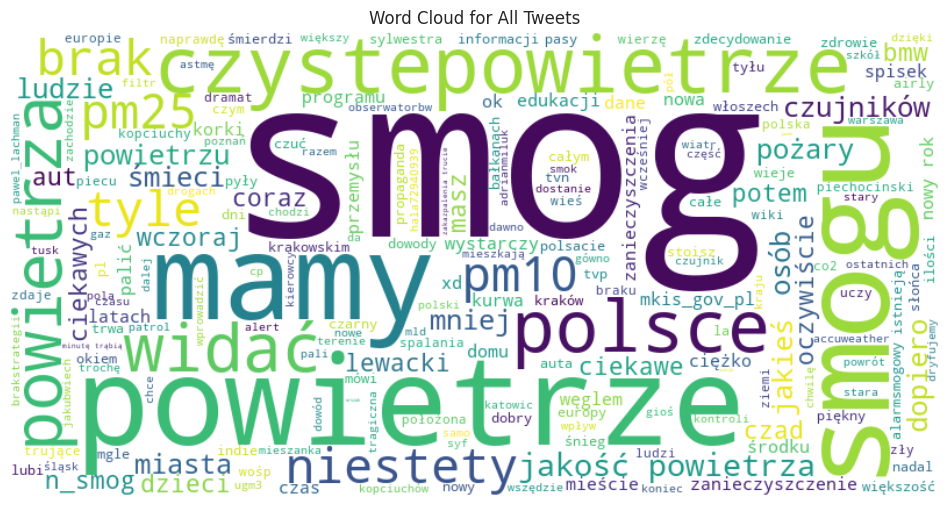

In [27]:
from user_code.stopwords import polish_stopwords

# 2. Remove punctuation, lowercase and tokenize the text
df['cleaned_text'] = df['text'].apply(lambda x: re.sub(r'[^\w\s]', '', x.lower()))

# 3. Tokenize and remove stopwords (Polish)
df['tokens'] = df['cleaned_text'].apply(lambda x: [word for word in x.split() if word not in polish_stopwords])

# 4. Word cloud visualization
all_text = ' '.join(df['tokens'].apply(lambda tokens: ' '.join(tokens)))
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)

plt.figure(figsize=(12, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Word Cloud for All Tweets')
plt.axis('off')
plt.show()

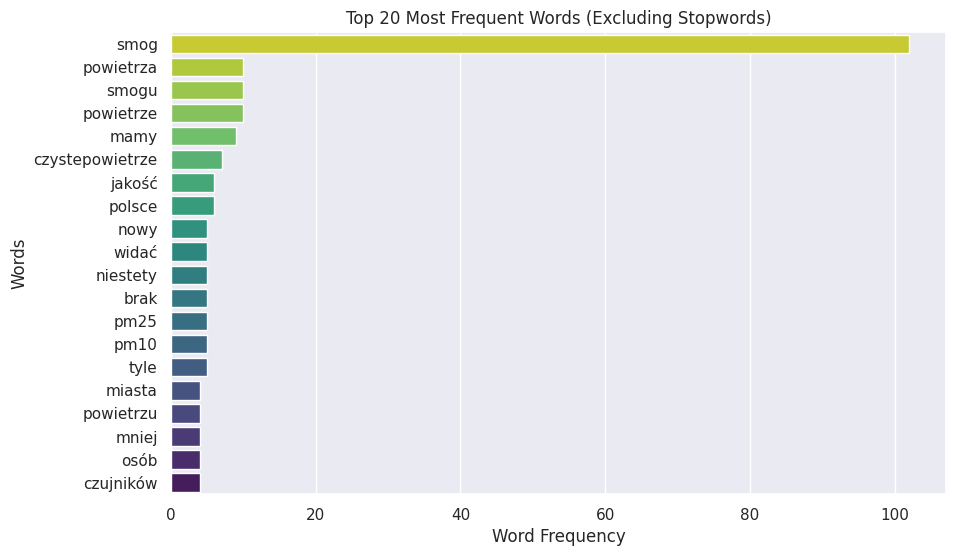

In [28]:
# 5. Most frequent words (excluding stopwords)
all_tokens = [word for tokens in df['tokens'] for word in tokens]
word_counts = Counter(all_tokens)
most_common_words = word_counts.most_common(20)

# Plot the top 20 most common words
words, counts = zip(*most_common_words)
plt.figure(figsize=(10, 6))
sns.barplot(x=list(counts), y=list(words), hue=list(words), palette='viridis_r')
plt.title("Top 20 Most Frequent Words (Excluding Stopwords)")
plt.xlabel("Word Frequency")
plt.ylabel("Words")
plt.show()

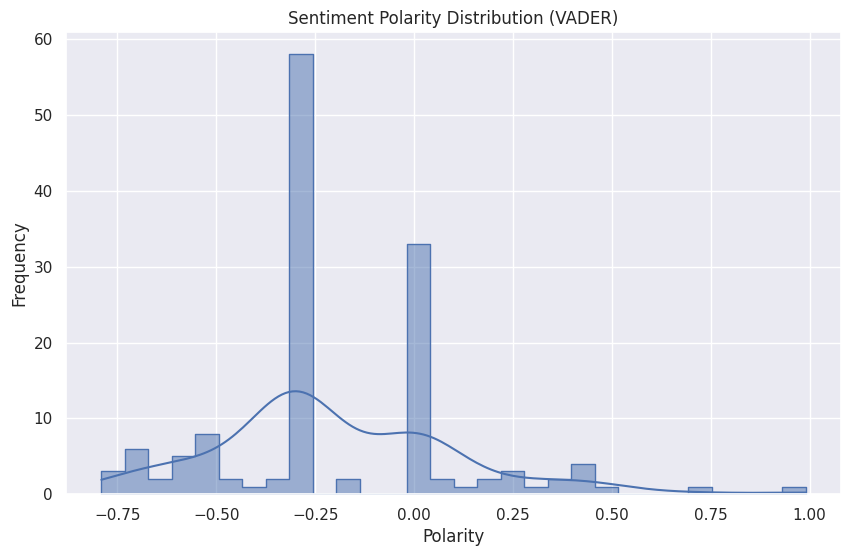

In [29]:
# 6. Sentiment analysis using VADER
analyzer = SentimentIntensityAnalyzer()

df['vader_sentiment'] = df['text'].apply(lambda x: analyzer.polarity_scores(x)['compound'])

# Plot sentiment polarity distribution
plt.figure(figsize=(10, 6))
sns.histplot(df['vader_sentiment'], bins=30, kde=True, element="step", cmap='viridis_r')
plt.title("Sentiment Polarity Distribution (VADER)")
plt.xlabel("Polarity")
plt.ylabel("Frequency")
plt.show()

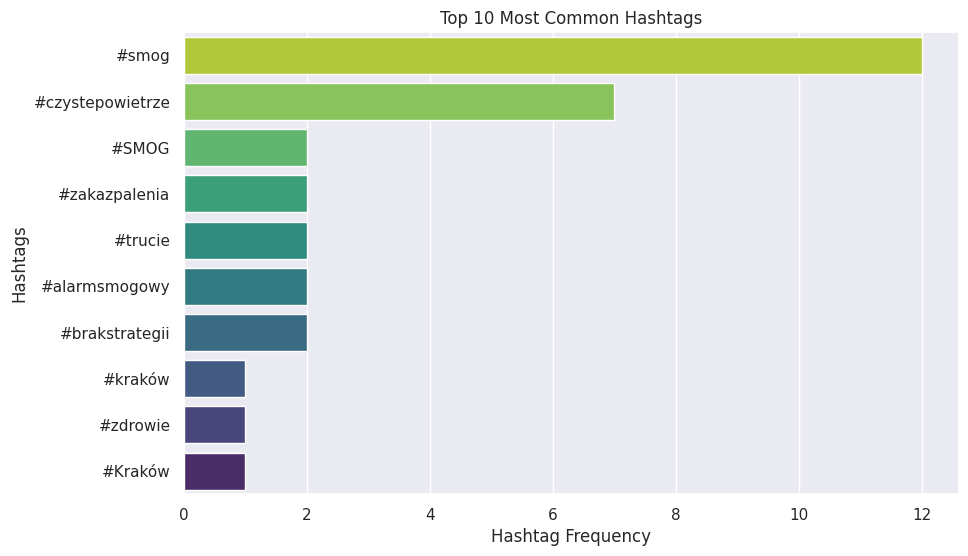

In [30]:
# 7. Extract and count hashtags
hashtags = [re.findall(r'#\w+', tweet) for tweet in df['text']]
hashtags_flat = [hashtag for sublist in hashtags for hashtag in sublist]
hashtag_counts = Counter(hashtags_flat)
top_hashtags = hashtag_counts.most_common(10)

# Plot the most common hashtags
hashtags, counts = zip(*top_hashtags)
plt.figure(figsize=(10, 6))
sns.barplot(x=list(counts), y=list(hashtags), hue=list(hashtags), palette='viridis_r')
plt.title("Top 10 Most Common Hashtags")
plt.xlabel("Hashtag Frequency")
plt.ylabel("Hashtags")
plt.show()

In [31]:
# 8. Topic Modeling (LDA)
# TF-IDF vectorization
vectorizer = TfidfVectorizer(stop_words=polish_stopwords)
X = vectorizer.fit_transform(df['cleaned_text'])

# LDA Topic Modeling
lda = LatentDirichletAllocation(n_components=5, random_state=42)
lda.fit(X)

# Display topics
for index, topic in enumerate(lda.components_):
    print(f"Topic {index + 1}:")
    print([vectorizer.get_feature_names_out()[i] for i in topic.argsort()[:-10 - 1:-1]])
    print("\n")

Topic 1:
['smog', 'n_smog', 'this', 'thefutballboy_1', 'rodrygo', 'xd', 'ogba', 'ref', 'nowy', 'city']


Topic 2:
['smog', 'fog', 'czystepowietrze', 'zdrowie', 'tymczasem', 'wesoło', 'mrzeżynie', 'zerodzialan', 'osób', 'dryfujemy']


Topic 3:
['smog', 'powietrze', 'powietrza', 'smogu', 'jakość', 'dane', 'alert', 'warszawski', 'httpstcowcdgzgrzfb', 'fotoodyseja']


Topic 4:
['smog', 'trujące', 'ciekawych', 'zabija', 'ciekawe', 'rok', 'powietrze', 'gęstszy', 'httpstcorcolkjbcpc', 'czujników']


Topic 5:
['smog', 'pytał', 'mamy', 'wośp', 'mkis_gov_pl', 'polsce', 'czad', 'dopadł', 'httpstcowdprxbrymg', 'problemów']


